In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
from matplotlib import rcParams
rcParams["figure.figsize"] = 12, 6
sns.set_style('darkgrid')

In [50]:
df = pd.read_csv('cleaned_data.csv')

# Feature Selection

In [51]:
from sklearn.model_selection import train_test_split

df_1 = df.copy() # deep copy

df_1.replace([np.inf, -np.inf], np.nan, inplace=True)
df_1.dropna(inplace=True)
df_1.shape

(14310, 22)

In [52]:
encoded_df1 = pd.get_dummies(df_1, drop_first=True)
print(f'Encoded df shape: {encoded_df1.shape}')

X = encoded_df1.drop('OilPeakRate', axis=1)
y = encoded_df1['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Encoded df shape: (14310, 30)
Training set shape: (11448, 29)
Test set shape: (2862, 29)


For feature selection, we are going to use Random Forest Regression to determine the importance of the features

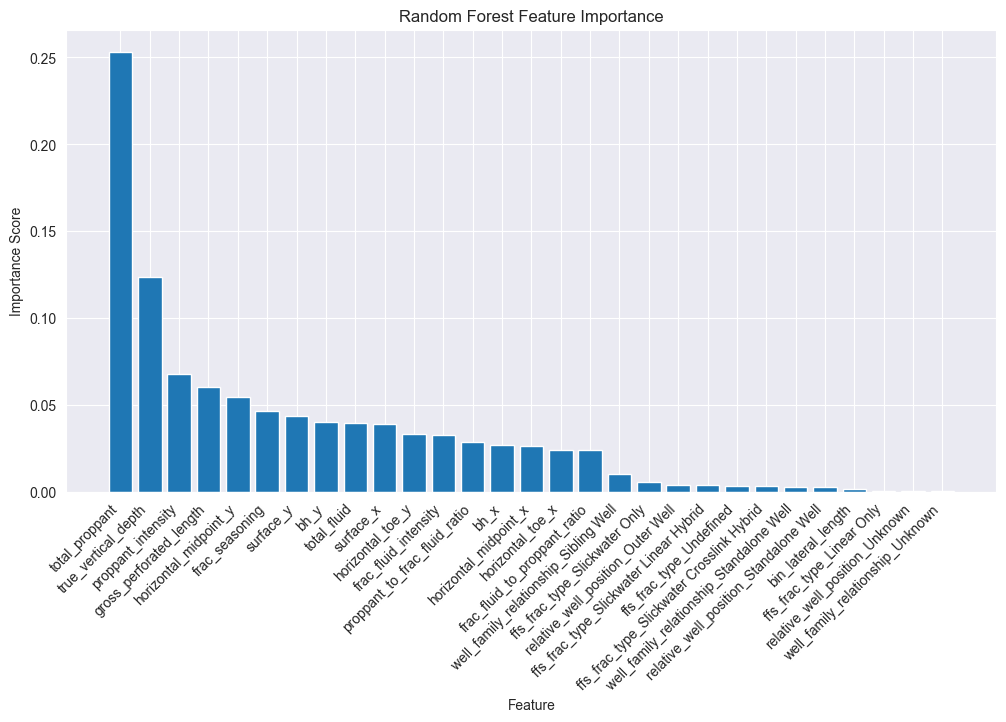

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=101)

rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [54]:
optimized_encoded_df = encoded_df1.drop(['ffs_frac_type_Linear Only', 
                                         'relative_well_position_Unknown', 'well_family_relationship_Unknown'], axis=1)
print(f'Optimized encoded df shape: {optimized_encoded_df.shape}')

Optimized encoded df shape: (14310, 27)


## Random Forest Regressor (without some features)

In [55]:
rf1 = RandomForestRegressor(n_estimators=100, random_state=45, )

opt_X_train, opt_X_test, opt_y_train, opt_y_test = train_test_split(optimized_encoded_df.drop('OilPeakRate', axis=1), 
                                                                    optimized_encoded_df['OilPeakRate'], 
                                                                    test_size=0.2, random_state=101)

rf1.fit(opt_X_train, opt_y_train)

from sklearn.metrics import mean_squared_error

rf1_pred = rf1.predict(opt_X_test)
rf1_train_pred = rf1.predict(opt_X_train)

mse = mean_squared_error(opt_y_test, rf1_pred)
train_mse = mean_squared_error(opt_y_train, rf1_train_pred)
rmse = np.sqrt(mse)
train_rmse = np.sqrt(train_mse)

print(f'Random Forest Regression Training RMSE: {train_rmse}')
print(f'Random Forest Regression Testing RMSE: {rmse}')


Random Forest Regression Training RMSE: 32.83212257769656
Random Forest Regression Testing RMSE: 86.16495491009059


lets try to see the difference between removing features and not

## Random Forest Regressor (with old features)

In [56]:
rf = RandomForestRegressor(n_estimators=100, random_state=45)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rf_pred_train = rf.predict(X_train)

from sklearn.metrics import mean_squared_error

# Calculate mean squared error
mse = mean_squared_error(y_test, rf_pred)
mse_train = mean_squared_error(y_train, rf_pred_train)

# Calculate root mean squared error
rmse = np.sqrt(mse)
train_rmse = np.sqrt(mse_train)

# Print the results
print('RMSE of Training set:', train_rmse)
print('RMSE of Testing set:', rmse)

RMSE of Training set: 32.66910984422599
RMSE of Testing set: 88.24528435838852


They seem to be rougly the same, with the non removed being a bit better. Lets keep the features in case they are needed, so our data can cover a wider dataset.

In [57]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=45)

cv_scores = cross_val_score(rf, opt_X_train, opt_y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-cv_scores)

print(f'Cross Validation RMSE: {cv_rmse}')

Cross Validation RMSE: [89.81668639 91.77287953 85.21168899 90.55285118 88.89210319]


## Random Forest with Scaling

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = scaler.fit_transform(optimized_encoded_df.drop('OilPeakRate', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=optimized_encoded_df.drop('OilPeakRate', axis=1).columns)

scaled_df['OilPeakRate'] = optimized_encoded_df['OilPeakRate']



rf = RandomForestRegressor(n_estimators=100, random_state=45)

X_train, X_test, y_train, y_test = train_test_split(scaled_df.drop('OilPeakRate', axis=1), scaled_df['OilPeakRate'], 
                                                    test_size=0.2, random_state=101)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rf_pred_train = rf.predict(X_train)



mse = mean_squared_error(y_test, rf_pred)
mse_train = mean_squared_error(y_train, rf_pred_train)

rmse = np.sqrt(mse)
train_rmse = np.sqrt(mse_train)

print('RMSE of Training set:', train_rmse)
print('RMSE of Testing set:', rmse)

RMSE of Training set: 32.8400196876675
RMSE of Testing set: 86.12177534285364


In [59]:

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

cv_rmse = np.sqrt(-cv_scores)

print(f'Cross Validation RMSE: {cv_rmse}')

Cross Validation RMSE: [89.79837831 91.76829042 85.18195362 90.5669946  88.8742689 ]


## XGBoost with Scaling

In [60]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=45)

xgb_reg.fit(X_train, y_train)

xgb_pred = xgb_reg.predict(X_test)

xgb_pred_train = xgb_reg.predict(X_train)

mse = mean_squared_error(y_test, xgb_pred)
mse_train = mean_squared_error(y_train, xgb_pred_train)

rmse = np.sqrt(mse)
train_rmse = np.sqrt(mse_train)

print('RMSE of Training set:', train_rmse)
print('RMSE of Testing set:', rmse)

RMSE of Training set: 49.87169000107328
RMSE of Testing set: 87.37847085168593


## kNN with Scaling

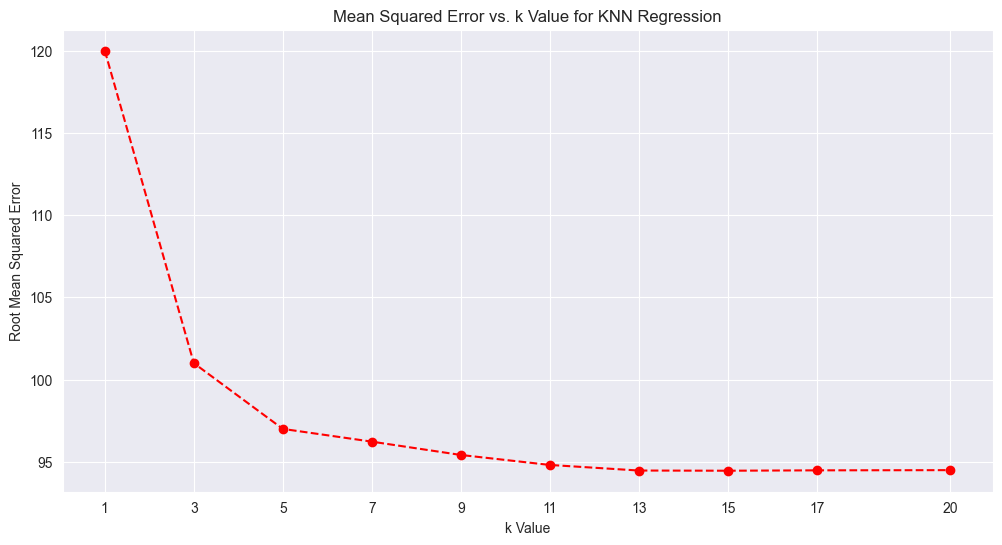

In [61]:
from sklearn.neighbors import KNeighborsRegressor

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
rmse_values = []

for k in k_values:
    knn_reg = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_reg.fit(X_train, y_train)

    y_pred = knn_reg.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

plt.plot(k_values, rmse_values, marker='o', linestyle='--', color='r')
plt.title('Mean Squared Error vs. k Value for KNN Regression')
plt.xlabel('k Value')
plt.ylabel('Root Mean Squared Error')
plt.xticks(k_values)
plt.grid(True)
plt.show() 

In [62]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19], 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'], 
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_knn_regressor = KNeighborsRegressor(**best_params)

best_knn_regressor.fit(X_train, y_train)

y_pred = best_knn_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("RMean Squared Error on Test Set:", np.sqrt(mse))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
RMean Squared Error on Test Set: 90.869100415273


Thus, the best score we can get on a kNN is around a 91 which is less than the random forest regressor. Lets try one more model, a neural network using tensorflow

## Neural Network
For this model, we have tried multiple different learning rates with optimizers and it is not giving us any value close to or less than the random forest model. Yet, this is still worth considering.

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear')) # 3 layers

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=2, 
                    batch_size=32, validation_split=0.2)

print(model.summary())

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

Epoch 1/100
358/358 - 1s - loss: 41658.0508 - val_loss: 13336.1934 - 1s/epoch - 4ms/step
Epoch 2/100
358/358 - 1s - loss: 12272.8848 - val_loss: 10791.1289 - 627ms/epoch - 2ms/step
Epoch 3/100
358/358 - 1s - loss: 11074.2695 - val_loss: 10325.6592 - 650ms/epoch - 2ms/step
Epoch 4/100
358/358 - 1s - loss: 10725.2432 - val_loss: 10096.9775 - 632ms/epoch - 2ms/step
Epoch 5/100
358/358 - 1s - loss: 10540.8193 - val_loss: 10028.6602 - 617ms/epoch - 2ms/step
Epoch 6/100
358/358 - 1s - loss: 10427.8389 - val_loss: 9874.2363 - 549ms/epoch - 2ms/step
Epoch 7/100
358/358 - 1s - loss: 10350.2910 - val_loss: 9833.5518 - 592ms/epoch - 2ms/step
Epoch 8/100
358/358 - 1s - loss: 10272.1621 - val_loss: 9787.8027 - 634ms/epoch - 2ms/step
Epoch 9/100
358/358 - 1s - loss: 10214.1875 - val_loss: 9857.6006 - 668ms/epoch - 2ms/step
Epoch 10/100
358/358 - 1s - loss: 10177.0146 - val_loss: 9733.2627 - 633ms/epoch - 2ms/step
Epoch 11/100
358/358 - 1s - loss: 10131.1787 - val_loss: 9741.5283 - 613ms/epoch - 2ms/

# Conclusion 
In conclusion, it appears that the Random Forest Regression model seems to be giving the best results. The other models did not do bad either as they were all under 100 rmse.